In [33]:
# Cell A: imports and settings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             precision_recall_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
import warnings
warnings.filterwarnings('ignore')


In [34]:
# Cell B: load and quick EDA
df = pd.read_csv(r"D:\project workspace\Credit_card_Fraud_Detection_Model\creditcard.csv")


print("Shape:", df.shape)
print(df['Class'].value_counts())
print(df.info())
display(df.head())


Shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [35]:
# Cell C: missing values and amount stats
print("Missing values per column:\n", df.isnull().sum())
print("\nAmount stats by class:")
display(df.groupby('Class')['Amount'].describe().T)


Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Amount stats by class:


Class,0,1
count,284315.000000,492.000000
mean,88.291022,122.211321
std,250.105092,256.683288
min,0.000000,0.000000
25%,5.650000,1.000000
50%,22.000000,9.250000
75%,77.050000,105.890000
max,25691.160000,2125.870000


In [36]:
# Cell D: split (we keep the full data; we will handle imbalance on training set)
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


Train: (227845, 30) Test: (56962, 30)
Train class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [37]:
# Cell E: pipeline with SMOTE + scaler + logistic regression
smote = SMOTE(random_state=42)
scaler = StandardScaler()
log = LogisticRegression(max_iter=1000, random_state=42)

pipeline = ImbPipeline([
    ('smote', smote),
    ('scaler', scaler),
    ('clf', log)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9898528843790597
Precision: 0.13414634146341464
Recall: 0.8979591836734694
F1: 0.23342175066312998
ROC AUC: 0.9764816590676788

Confusion matrix:
 [[56296   568]
 [   10    88]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962



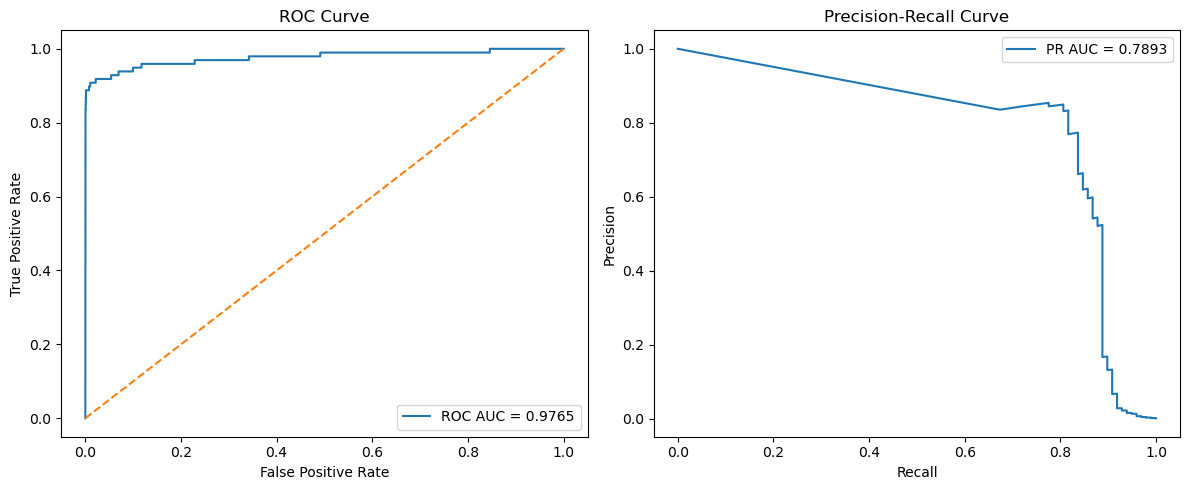

In [38]:
#Cell F:Roc and precision recall
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
pr_precision, pr_recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(pr_recall, pr_precision)

# Plotting
plt.figure(figsize=(12,5))

# -------------------- ROC CURVE --------------------
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# -------------------- PRECISION-RECALL CURVE --------------------
plt.subplot(1,2,2)
plt.plot(pr_recall, pr_precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
# Cell G: quick model comparison using imbalanced pipeline for each

import time
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score



models = {
    'Logistic': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=12, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=6, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
}

results = {}
for name, clf in models.items():
    print(f"\n---- Training {name} ----")
    start = time.time()
    pipe = ImbPipeline([('smote', SMOTE(random_state=42)),
                        ('scaler', StandardScaler()),
                        ('clf', clf)])
    pipe.fit(X_train, y_train)         
    proba = pipe.predict_proba(X_test)[:,1]
    pred = pipe.predict(X_test)
    elapsed = time.time() - start
    results[name] = {
        'precision': precision_score(y_test, pred, zero_division=0),
        'recall': recall_score(y_test, pred),
        'f1': f1_score(y_test, pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, proba),
        'time_s': round(elapsed, 2)
    }
    print(f"{name} done in {elapsed:.2f}s")

import pandas as pd
res_df = pd.DataFrame(results).T
display(res_df.sort_values('roc_auc', ascending=False))



---- Training Logistic ----
Logistic done in 9.91s

---- Training RandomForest ----
RandomForest done in 113.36s

---- Training XGBoost ----
XGBoost done in 6.79s


,precision,recall,f1,roc_auc,time_s
RandomForest,0.594406,0.867347,0.705394,0.987109,113.36
XGBoost,0.656250,0.857143,0.743363,0.983418,6.79
Logistic,0.134146,0.897959,0.233422,0.976482,9.91


,threshold,precision,recall,f1
0,0.01,0.272727,0.887755,0.417266
1,0.02,0.359504,0.887755,0.511765
2,0.03,0.415459,0.877551,0.563934
3,0.04,0.447917,0.877551,0.593103
4,0.05,0.483146,0.877551,0.623188
13,0.14,0.629630,0.867347,0.729614
20,0.21,0.669291,0.867347,0.755556
18,0.19,0.664062,0.867347,0.752212
17,0.18,0.658915,0.867347,0.748899
16,0.17,0.648855,0.867347,0.742358


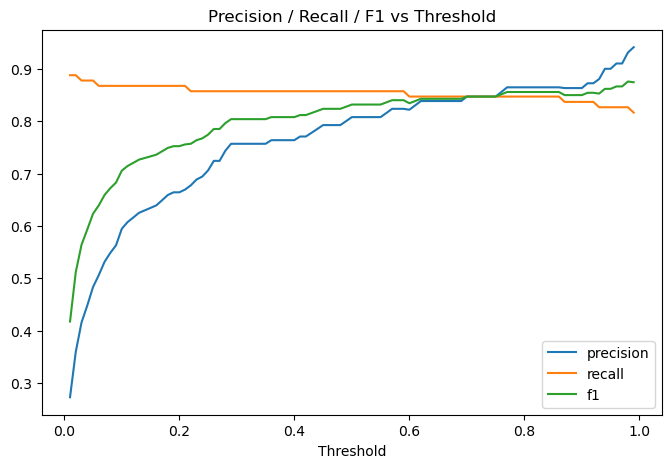

In [40]:
# Cell H: threshold tuning example using the best model (replace with chosen model pipeline)
best_pipe = ImbPipeline([('smote', SMOTE(random_state=42)),
                         ('scaler', StandardScaler()),
                         ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
best_pipe.fit(X_train, y_train)
y_scores = best_pipe.predict_proba(X_test)[:,1]

# try thresholds
thresholds = np.linspace(0.01, 0.99, 99)
metrics = []
for t in thresholds:
    preds = (y_scores >= t).astype(int)
    metrics.append((t, precision_score(y_test, preds), recall_score(y_test, preds), f1_score(y_test, preds)))

metrics_df = pd.DataFrame(metrics, columns=['threshold','precision','recall','f1'])
display(metrics_df.sort_values('recall', ascending=False).head(10))

# Plot precision-recall vs threshold
plt.figure(figsize=(8,5))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='precision')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='recall')
plt.plot(metrics_df['threshold'], metrics_df['f1'], label='f1')
plt.xlabel('Threshold'); plt.legend(); plt.title('Precision / Recall / F1 vs Threshold'); plt.show()


In [41]:
# CEll I
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# use a small subset to speed things up ---
X_train_small = X_train.sample(frac=0.3, random_state=42)  
y_train_small = y_train.loc[X_train_small.index]

pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist = {
    'clf__n_estimators': [20, 50, 100],    
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

rsearch = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,                     
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3),
    verbose=2,                    
    n_jobs=-1,
    random_state=42,
    refit=True
)

# Fit on the SMALL subset for quick tuning; change to X_train/y_train when ready
rsearch.fit(X_train_small, y_train_small)

print("Best params:", rsearch.best_params_)
print("Best CV score:", rsearch.best_score_)
best_est = rsearch.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 6}
Best CV score: 0.963294304642413


In [42]:
# Cell J: save the chosen model pipeline (example using best_pipe)
joblib.dump(best_pipe, 'fraud_detection_pipeline.pkl')
print("Saved pipeline to fraud_detection_pipeline.pkl")


Saved pipeline to fraud_detection_pipeline.pkl


V14       0.676121
V4        0.061359
V12       0.032148
V17       0.023975
V1        0.016856
V3        0.016855
V13       0.013714
V8        0.013663
V10       0.010230
V21       0.010172
V9        0.009979
V7        0.009240
V18       0.009150
Amount    0.008449
V26       0.008091
V11       0.007256
V28       0.007222
V16       0.007144
V2        0.006676
Time      0.006537
dtype: float32

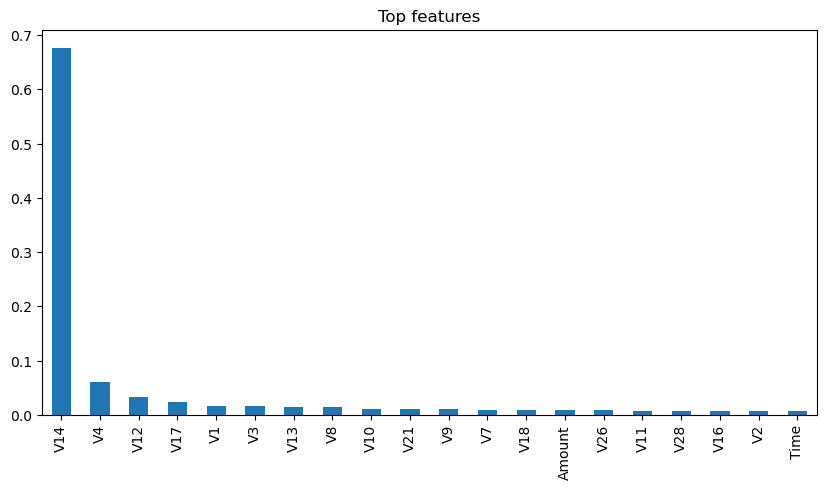

In [43]:
# Cell K: feature importance (example for RandomForest or XGBoost)
# If using tree model with feature_importances_
if hasattr(best_pipe.named_steps['clf'], 'feature_importances_'):
    importances = best_pipe.named_steps['clf'].feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    display(feat_imp.head(20))
    feat_imp.head(20).plot.bar(figsize=(10,5)); plt.title('Top features'); plt.show()

# If using logistic regression, show coefficients
elif hasattr(best_pipe.named_steps['clf'], 'coef_'):
    coef = best_pipe.named_steps['clf'].coef_.ravel()
    coef_s = pd.Series(coef, index=X.columns).sort_values(key=abs, ascending=False)
    display(coef_s.head(20))


In [44]:
y_pred_new = best_pipe.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_new = accuracy_score(y_test, y_pred_new)
print("New Model Test Accuracy:", accuracy_new)


New Model Test Accuracy: 0.999403110845827
